# Import Libraries

In [2]:
import openvino as ov
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Models

In [3]:
core = ov.Core()

model_emo = core.read_model(model='models/emotions-recognition-retail-0003.xml')
compiled_model_emo = core.compile_model(model = model_emo, device_name = "CPU")

input_layer_emo = compiled_model_emo.input(0)
output_layer_emo = compiled_model_emo.output(0)

print("Input shape:", input_layer_emo.shape)
print("output shape:", output_layer_emo.shape)

model_face = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model_face = core.compile_model(model = model_face, device_name = "CPU")

input_layer_face = compiled_model_face.input(0)
output_layer_face = compiled_model_face.output(0)

print("Input shape:", input_layer_face.shape)
print("output shape:", output_layer_face.shape)

Input shape: [1,3,64,64]
output shape: [1,5,1,1]
Input shape: [1,3,384,672]
output shape: [1,1,200,7]


# Function

In [29]:
def preprocess(image, input_layer):

        resized_image = cv2.resize(image, (64, 64))
        transposed_image = resized_image.transpose(2,0,1)
        input_image = np.expand_dims(transposed_image,0)
        
        return input_image

def preprocess_face(image, input_layer):

        resized_image = cv2.resize(image, (672, 384))
        transposed_image = resized_image.transpose(2,0,1)
        input_image = np.expand_dims(transposed_image,0)
        
        return input_image

In [30]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()

    scores = results[:, 2]
    boxes  = results[:, -4:]

    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]

    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)

    return face_boxes, scores

In [31]:
def draw_faceboxes(image, face_boxes, scores):
    
    show_image = image.copy()

    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=(0, 200, 0), thickness=2)

    return show_image

In [68]:
def draw_emotions(face_boxes, image, show_image):
    EMOTION_NAMES = ['netural', 'happy', 'sad', 'surprise', 'anger']
    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        face = image[ymin:ymax, xmin:xmax]
        input_image = preprocess(face, input_layer_emo)
        results = compiled_model_emo([input_image])[output_layer_emo]

        results_emo = results.squeeze()
        index = np.argmax(results_emo)

        text = EMOTION_NAMES[index]
        cv2.putText(show_image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 7, (0, 200, 0), 10)
        

# Do Inference

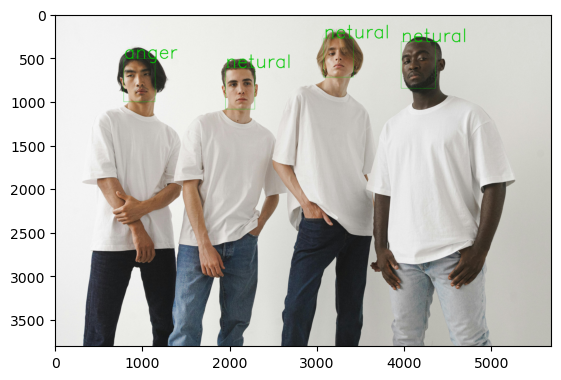

In [69]:
image = cv2.imread("data/people.jpg")

input_image = preprocess_face(image, input_layer_face)
results = compiled_model_face([input_image])[output_layer_face]

confidence_threshold = .95
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
show_image = draw_faceboxes(image, face_boxes, scores)

draw_emotions(face_boxes, image, show_image)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

[0.66 0.03 0.07 0.01 0.23] 0 netural


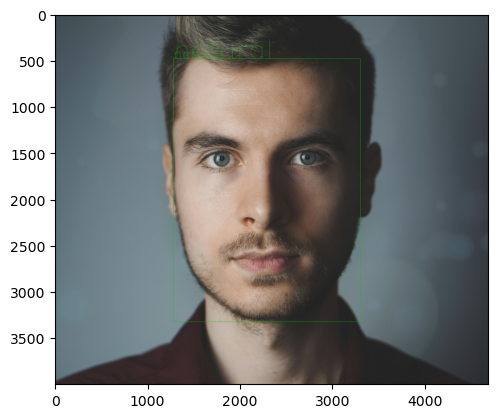

In [49]:
EMOTION_NAMES = ['netural', 'happy', 'sad', 'surprise', 'anger']
for i in range(len(face_boxes)):
    xmin, ymin, xmax, ymax = face_boxes[i]
    face = image[ymin:ymax, xmin:xmax]
    input_image = preprocess(face, input_layer_emo)
    results = compiled_model_emo([input_image])[output_layer_emo]

    results_emo = results.squeeze()
    index = np.argmax(results_emo)

    text = EMOTION_NAMES[index]
    cv2.putText(show_image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 200, 0), 2)
    

    print(np.round(results_emo,2), index, text)
    plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))